In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from factor_analyzer import Rotator
from sklearn.decomposition import PCA

In [2]:
df_behavioral = pd.read_csv("Behavioral_Data",index_col="Subject")
df_behavioral.index = df_behavioral.index.astype(str)
behavioral_columns = ['PicSeq_Unadj','CardSort_Unadj','Flanker_Unadj','PMAT24_A_CR','ReadEng_Unadj','PicVocab_Unadj','ProcSpeed_Unadj','VSPLOT_TC','SCPT_SEN','SCPT_SPEC','IWRD_TOT','ListSort_Unadj','MMSE_Score',
                     'PSQI_Score','Endurance_Unadj','Dexterity_Unadj','Strength_Unadj','Odor_Unadj','PainInterf_Tscore','Taste_Unadj','Mars_Final','Emotion_Task_Face_Acc','Language_Task_Math_Avg_Difficulty_Level',
                     'Language_Task_Story_Avg_Difficulty_Level','Relational_Task_Acc','Social_Task_Perc_Random','Social_Task_Perc_TOM','WM_Task_Acc','NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E','ER40_CR','ER40ANG','ER40FEAR',
                     'ER40HAP','ER40NOE','ER40SAD','AngAffect_Unadj','AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj','FearSomat_Unadj','Sadness_Unadj','LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj',
                     'Loneliness_Unadj','PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj','PercStress_Unadj','SelfEff_Unadj','DDisc_AUC_40K','GaitSpeed_Comp']
behavioral_names =  ['Visual Episodic Memory','Cognitive Flexibility','Inhibition','Fluid Intelligence','Reading','Vocabulary','Processing Speed','Spatial Orientation','Sustained Attention_Sens','Sustained Attention_Spec','Verbal Episodic Memory','Working Memory (List soting)','Cognitive Status',
                 'Sleep Quality','Walking Endurance','Manual Dexterity','Grip Strength','Odor Identification','Pain Interference Survey','Taste Intensity','Contrast Sensitivity','Emotional Face Matching','Arithmetic',
                 'Story Comprehension','Relational Processing','Social Cognition_Random','Social Cognition_Interaction','Working Memory (N-back)','Agreeableness','Openness','Conscientiousness','Neuroticism','Extraversion','Emot. Recog. _ Total','Emot. Recog. _ Angry','Emot. Recog. _Fear',
                 'Emot. Recog. _ Happy','Emot. Recog. _ Neutral','Emot. Recog. _ Sad','Anger _ Affect','Anger _ Hostility','Anger _ Aggression','Fear _ Affect','Fear _ Somatic Arousal','Sadness','Life Satisfaction','Meaning & Purpose','Positive Affect','Friendship',
                 'Loneliness','Perceived Hostility','Perceived Rejection','Emotional Support','Instrument Support','Perceived Stress','Self-Efficacy','Delay Discounting','Walking Speed']
df_behavioral = df_behavioral[behavioral_columns]


In [3]:
imputer = IterativeImputer(max_iter=20, random_state=0)
df_imputed = imputer.fit_transform(df_behavioral)
zscore = StandardScaler()
df_scaled = zscore.fit_transform(df_imputed)
reducer = umap.UMAP(n_components=3)
df_umap = reducer.fit_transform(df_scaled)


In [4]:
# Compute correlation
correlations = np.corrcoef(df_scaled.T, df_umap.T)[:df_scaled.shape[1],df_scaled.shape[1]:]

In [5]:
pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_colwidth", None)  # Avoid truncating column names

corr_df = pd.DataFrame(
    correlations,
    index=behavioral_names,
    columns=[f"UMAP_Comp_{j+1}" for j in range(df_umap.shape[1])]
)
#print(corr_df)

In [6]:
data = {
    ('UMAP_1','Name'): corr_df.iloc[:,0].abs().nlargest(10).index.to_list(),
    ('UMAP_1','Value'): corr_df.iloc[:,0].abs().nlargest(10).values,

    ('UMAP_2','Name'): corr_df.iloc[:,1].abs().nlargest(10).index.to_list(),
    ('UMAP_2','Value'): corr_df.iloc[:,1].abs().nlargest(10).values,

    ('UMAP_3','Name'): corr_df.iloc[:,2].abs().nlargest(10).index.to_list(),
    ('UMAP_3','Value'): corr_df.iloc[:,2].abs().nlargest(10).values,

}
pd.set_option('display.width', 1000)
df = pd.DataFrame(data)
print(df)

                UMAP_1                         UMAP_2                                  UMAP_3          
                  Name     Value                 Name     Value                          Name     Value
0           Loneliness  0.604003              Sadness  0.704828       Working Memory (N-back)  0.602005
1  Perceived Rejection  0.599567           Loneliness  0.671176         Relational Processing  0.566197
2     Perceived Stress  0.597186     Perceived Stress  0.651743                       Reading  0.559525
3    Emotional Support  0.594541       Anger _ Affect  0.638931                    Vocabulary  0.551534
4    Anger _ Hostility  0.590393          Neuroticism  0.627212            Fluid Intelligence  0.542111
5    Life Satisfaction  0.577734        Fear _ Affect  0.621670           Story Comprehension  0.509209
6          Neuroticism  0.566409  Perceived Rejection  0.585220         Cognitive Flexibility  0.461089
7    Meaning & Purpose  0.554767      Positive Affect  0.555475 

PCA

In [7]:
# 80 specific subjects same as the paper
train_subs = (
    pd.read_csv("MMP_HCP_80_subs_componentscoreestimation.txt", header=None)
    .values.flatten()
    .astype(str)
)  # 80 subjects

# 753 specific subject for main analysis same as the paper
test_subs = (
    pd.read_csv("MMP_HCP_753_subs.txt", header=None).values.flatten().astype(str)
)  # 753 subjects

# Load the dataset
full_df = pd.read_csv("Behavioral_Data", index_col="Subject")[behavioral_columns]
full_df.index = full_df.index.astype(str)
test_df = full_df.loc[test_subs]
train_df = full_df.loc[train_subs]


imputer = IterativeImputer(max_iter=20, random_state=0)
df_imputed = imputer.fit_transform(train_df)

scaler = StandardScaler()
df_trans = scaler.fit_transform(df_imputed)

pca = PCA(n_components=3,random_state=42)
df_pca = pca.fit_transform(df_trans)
loadings = pca.components_
loadings = pd.DataFrame(loadings.T,index=behavioral_names)

rotator = Rotator(method="varimax")
rotated_loadings = rotator.fit_transform(loadings)
rotated_loadings = pd.DataFrame(rotated_loadings,index=behavioral_names)

data_pca = {
    ('PCA0','Name'): rotated_loadings[0].abs().nlargest(10).index.to_list(),
    ('PCA0','Value'): rotated_loadings[0].abs().nlargest(10).values,

    ('PCA1','Name'): rotated_loadings[1].abs().nlargest(10).index.to_list(),
    ('PCA1','Value'): rotated_loadings[1].abs().nlargest(10).values,

    ('PCA2','Name'): rotated_loadings[2].abs().nlargest(10).index.to_list(),
    ('PCA2','Value'): rotated_loadings[2].abs().nlargest(10).values,

}
pd.set_option('display.width', 1000)
df_pca = pd.DataFrame(data_pca)
print(df_pca)

                  PCA0                                    PCA1                                    PCA2          
                  Name     Value                          Name     Value                          Name     Value
0              Sadness  0.255977                       Reading  0.302398        Emot. Recog. _ Neutral  0.350870
1     Perceived Stress  0.255488                    Vocabulary  0.289734          Emot. Recog. _ Total  0.349149
2           Loneliness  0.245144            Fluid Intelligence  0.261402       Social Cognition_Random  0.302970
3          Neuroticism  0.239447           Spatial Orientation  0.249257  Social Cognition_Interaction  0.299935
4      Positive Affect  0.233404        Visual Episodic Memory  0.237045           Odor Identification  0.227335
5    Meaning & Purpose  0.233218         Relational Processing  0.237016            Emot. Recog. _ Sad  0.219767
6  Perceived Rejection  0.232838           Story Comprehension  0.231846                Anger _ 

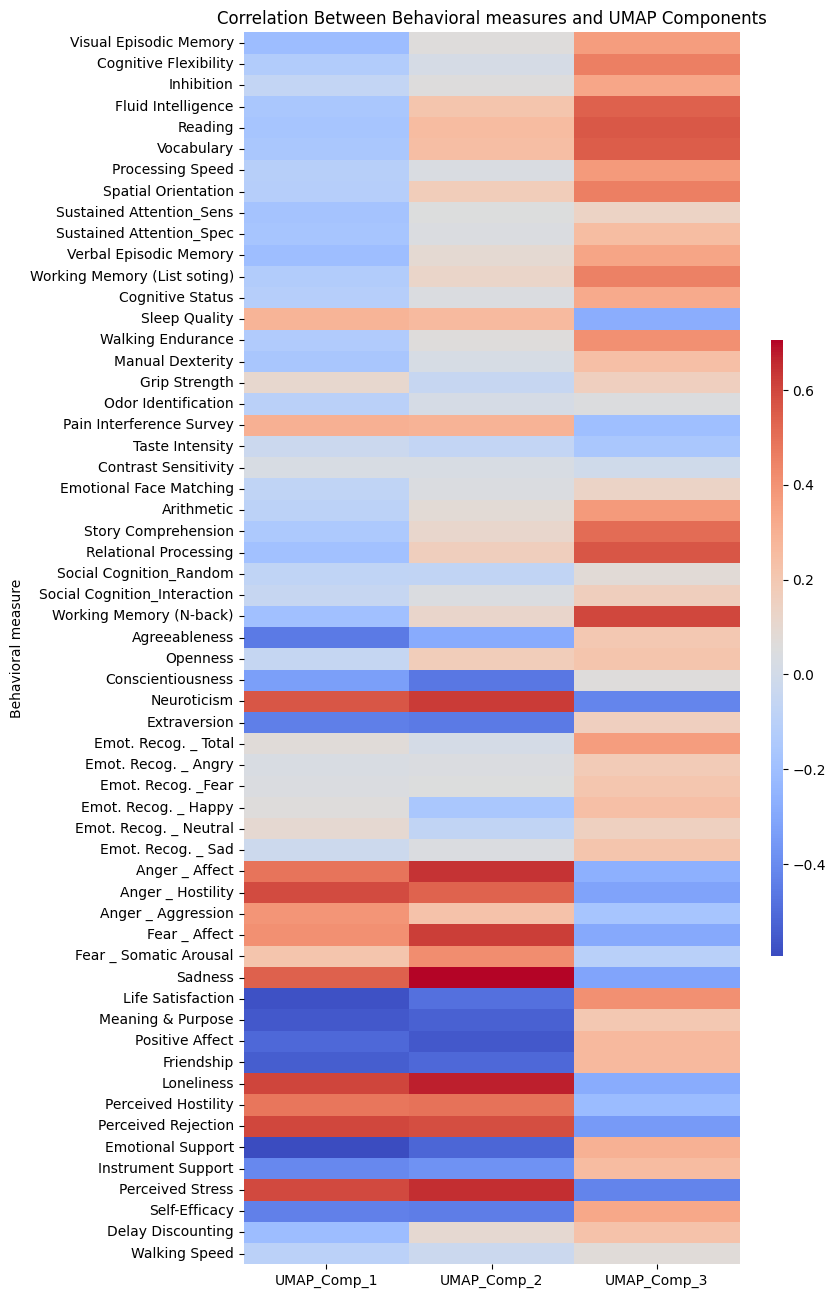

In [8]:
plt.figure(figsize=(8,16))
sns.heatmap(corr_df, cmap="coolwarm",cbar_kws={"shrink":0.5,"aspect":50})
plt.title("Correlation Between Behavioral measures and UMAP Components")
plt.ylabel("Behavioral measure")
plt.show()

Investigate the components in cross-valdation way.

In [ ]:
from sklearn.model_selection import KFold
cv_behavioral = pd.read_csv("Behavioral_Data",index_col="Subject")
cv_behavioral.index = cv_behavioral.index.astype(str)
cv_behavioral = cv_behavioral[behavioral_columns]

kf = KFold(n_splits = 10, shuffle=True, random_state=42)
fold_correlation = []
for fold_idx, (train_idx,test_idx) in enumerate(kf.split(cv_behavioral)):
    cv_train, cv_test = cv_behavioral.iloc[train_idx,:], cv_behavioral.iloc[test_idx,:] 
    imputer_cv = IterativeImputer(max_iter=20,random_state=42)
    cv_train_imputed = imputer_cv.fit_transform(cv_train)
    scaler_cv = StandardScaler()
    cv_train_scaled = scaler_cv.fit_transform(cv_train_imputed)
    reducer = umap.UMAP(n_components=3,random_state=42) 
    reducer.fit(cv_train_scaled)

    cv_test_imputed = imputer_cv.transform(cv_test)
    cv_test_scaled = scaler_cv.transform(cv_test_imputed)
    cv_test_umap = reducer.transform(cv_test_scaled)

    cv_correlation = np.corrcoef(cv_test_scaled.T,cv_test_umap.T)[:cv_test_scaled.shape[1],cv_test_scaled.shape[1]:]

    cv_corr_df = pd.DataFrame(
        cv_correlation,
        index = behavioral_names,
        columns = [f"UMAP_component_{i+1}" for i in range(cv_test_umap.shape[1])]
    )
    fold_correlation.append(cv_corr_df)

    #print(f"Fold {fold_idx + 1} correlations:")
    #print(cv_corr_df)
    #print("\n")


In [19]:
average_corr = sum(fold_correlation) / len(fold_correlation)
#print("Average Correlation Across Folds:")
#print(average_corr)

data_cv = {
    ('UMAP1','Name'): average_corr.iloc[:,0].abs().nlargest(10).index.to_list(),
    ('UMAP1','Value'): average_corr.iloc[:,0].abs().nlargest(10).values,

    ('UMAP2','Name'): average_corr.iloc[:,1].abs().nlargest(10).index.to_list(),
    ('UMAP2','Value'): average_corr.iloc[:,1].abs().nlargest(10).values,

    ('UMAP3','Name'): average_corr.iloc[:,2].abs().nlargest(10).index.to_list(),
    ('UMAP3','Value'): average_corr.iloc[:,2].abs().nlargest(10).values,

}
df_cv = pd.DataFrame(data_cv)

print("Top 10 Behavioral Measures in each Component under cross-valdiation")
print(df_cv)

Top 10 Behavioral Measures in each Component under cross-valdiation
                          UMAP1                          UMAP2                          UMAP3          
                           Name     Value                 Name     Value                 Name     Value
0       Working Memory (N-back)  0.430143              Sadness  0.431343          Neuroticism  0.163798
1         Relational Processing  0.395490        Fear _ Affect  0.422466              Sadness  0.157145
2            Fluid Intelligence  0.384278           Loneliness  0.392884       Anger _ Affect  0.151199
3           Story Comprehension  0.372615          Neuroticism  0.380611     Perceived Stress  0.142112
4                       Reading  0.364797       Anger _ Affect  0.371729  Perceived Rejection  0.137883
5                    Vocabulary  0.345922     Perceived Stress  0.370528           Loneliness  0.123184
6  Working Memory (List soting)  0.330027      Positive Affect  0.324495        Fear _ Affect  0.121

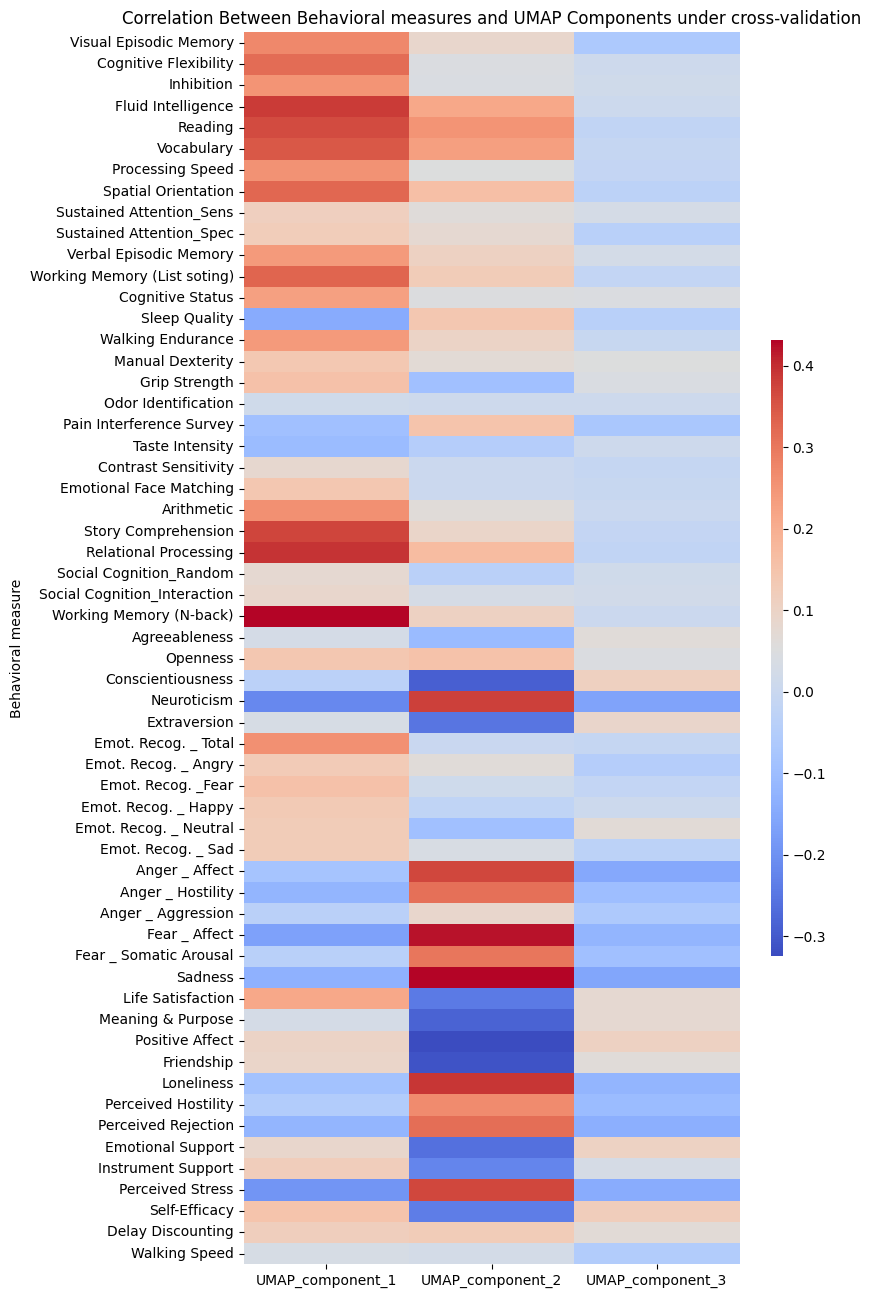

In [21]:
plt.figure(figsize=(8,16))
sns.heatmap(average_corr, cmap="coolwarm",cbar_kws={"shrink":0.5,"aspect":50})
plt.title("Correlation Between Behavioral measures and UMAP Components under cross-validation")
plt.ylabel("Behavioral measure")
plt.show()